In [ ]:
""" 
[HERE: JUST LOADING PRE-EXTRACTED MPs andscoring, and optimizing based on datsaets.]
"""

## OPTIMIZE LIBRARY (I.E., MODEL PARAMS) GIVEN MPS

For each iteration, fit models using paritcular params (modelver list), whiel other params are fit to entire
dataset. Then test (lines5 test tasks) against these different models. 

This allows asking which model (e.g.m full, vs. partials) best accounts for difference in behavior

Here does entier thing - fitting, plotting, svaing.



In [1]:
from pythonlib.tools.expttools import findPath
from pythonlib.dataset.dataset import Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:
SDIR_MAIN = "/data2/analyses/database/combined-bpl_refit"


In [3]:
def params_by_expt(D, expt):
    # ==== mods of D
    if expt in ["biasdir2", "biasdir3", "biasdir4"]:
        if "block_code" not in D.Dat.columns:
            # Assign code names to blocks
            block_code_names = {}

            for i in [1,2]:
                block_code_names[i] = "base"
            for i in [3,4, 5]:
                block_code_names[i] = "1lr"
            for i in [6,7, 8]:
                block_code_names[i] = "2rl"

            from pythonlib.tools.pandastools import applyFunctionToAllRows

            def F(x):
                bk = x["block"]
                return block_code_names[bk]
            D.Dat = applyFunctionToAllRows(D.Dat, F, "block_code")

    
    # ============ PRELIM, THINGS SPECIFIC TO EACH EXPT
    if expt in ["biasdir2", "biasdir3", "biasdir4"]:

        # == grouping method
        group = ['animal', 'block_code', 'monkey_train_or_test']

        # == which data touse for efitting libraries
        libraries_to_apply_inds = [
            (animal, "base", 'train'),
            (animal, "1lr", "train"),
            (animal, "2rl", "train")]

        # == Two models, will take mod2 minus mod1
        mod1 = (animal, "1lr", "train")
        mod2 = (animal, "2rl", "train")

        # == to filter, what will call "test"
        FiltTest = {"monkey_train_or_test":["test"]}
        
        # == for indexing into final aggregated dframe
        column_dsets = "block_code"
        column_levels = ["1lr", "2rl"]
        
    elif expt in ["lines5"]:

        # == grouping method                
        group = ['animal', 'expt', 'epoch', 'monkey_train_or_test']

        # == which data touse for efitting libraries
        libraries_to_apply_inds = [
             (animal, expt, 1, 'train'),
             (animal, expt, 2, 'train')]

        # == Two models, will take mod2 minus mod1
        mod1 = (animal, 'lines5', 1, 'train')
        mod2 = (animal, 'lines5', 2, 'train')

        # == to filter, what will call "test"
        FiltTest = {"monkey_train_or_test":["test"],
        #      "character":[],
             "taskgroup":["G3"]}

        # == for indexing into final aggregated dframe
        column_dsets = "epoch"
        column_levels = [1,2]
    else:
        assert False
    
    return D, group, libraries_to_apply_inds, mod1, mod2, FiltTest, column_dsets, column_levels

Did not load data!!!
Searching using this string:
/data2/analyses/database//*Pancho*lines5*/*dat*.pkl
-- Splitting off dir from fname
Found this many paths:
1
---
/data2/analyses/database/Pancho-lines5-formodeling-210329_014835
Searching using this string:
/data2/analyses/database/BEH/*Pancho*lines5*/*dat*.pkl
-- Splitting off dir from fname
Found this many paths:
0
----------------
Currently loading: /data2/analyses/database/Pancho-lines5-formodeling-210329_014835
Loaded metadat:
{'sketchpad_edges': array([[-327.2, -327.2],
       [ 327.2,  429.6]])}
----
Resetting index
=== CLEANING UP self.Dat ===== 
ORIGINAL: online abort values
Series([], Name: online_abort, dtype: int64)
kept 6949 out of 6949
removed all cases with online abort not None
Deleted unused columns from self.Dat
Searching using this string:
/data2/analyses/database/Pancho-lines5-formodeling-210329_014835/*infer_MPs_from_strokes*/*params*.pkl
-- Splitting off dir from fname
Found this many paths:
1
---
/data2/analyses/d

appended col to self.Dat:
index_grp
-- SCORING, using this model:
('Pancho', 'lines5', 1, 'train')
('Pancho', 'lines5', 2, 'train')
/data2/analyses/database/combined-bpl_refit/Pancho-lines5-full-210506_224847


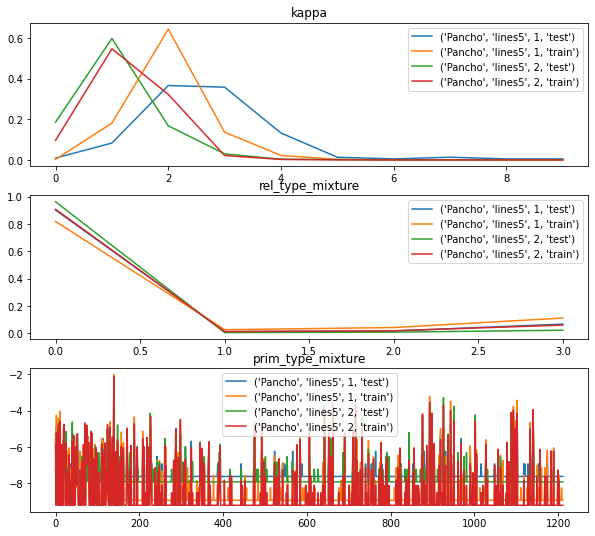

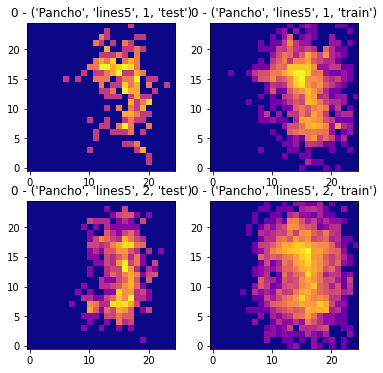

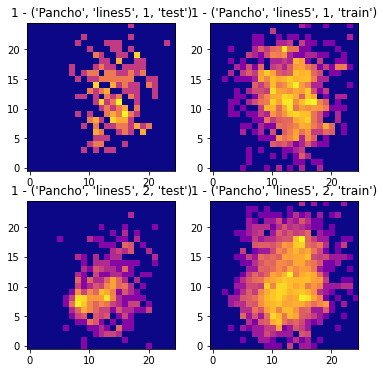

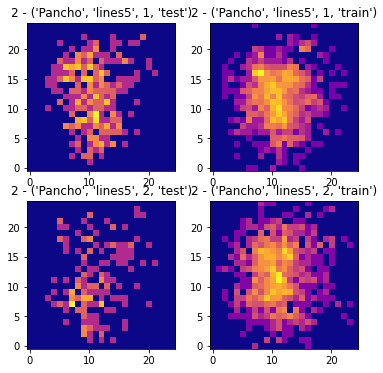

In [4]:
# animallist = ["Pancho", "Red"]
# modelverlist = [
#     "full", 'kappa', 'rel_type_mixture', 'prim_type_mixture', 'spatial_hist']
modelverlist = [
    "full"]
animallist = ["Pancho"]
# modelverlist = [
#     'prim_type_mixture', 'spatial_hist']
exptlist = ["lines5"]
# expt = "biasdir4" # 4>6 in terms of dataset size (Pancho, other direction for Red)
# exptlist = ["biasdir4"]

for expt in exptlist:

    # modelver = "full" # kappa', 'rel_type_mixture', 'prim_type_mixture', 'spatial_hist
    for modelver in modelverlist:
        for animal in animallist:

            # == load MPs (use wrapper through datasets, since each dataset is associated with MP)
            import pandas as pd
            import pickle 
            from pythonlib.dataset.dataset import Dataset
            from pythonlib.bpl.strokesToProgram import *

            # old version, where gave datasets by hand
#             if expt=="lines5":
#                 if animal=="Red":
#                     path_list = ["/data2/analyses/database/Red-lines5-formodeling-210329_005719"]
#                 elif animal=="Pancho":
#                     path_list = ["/data2/analyses/database/Pancho-lines5-formodeling-210329_014835"]
#             elif expt=="biasdir3":
#                 if animal=="Red":
#                     path_list = [
#                         "/data2/analyses/database/Red-biasdir3-formodeling-210406_014350"]
#                 elif animal=="Pancho":
#                     path_list = [
#                         "/data2/analyses/database/Pancho-biasdir3-formodeling-210406_014356"]
#             elif expt=="biasdir2":
#                 if animal=="Red":
#                     path_list = [
#                         "/data2/analyses/database/Red-biasdir2-formodeling-210406_014229/"]
#                 elif animal=="Pancho":
#                     path_list = [
#                         "/data2/analyses/database/Pancho-biasdir2-formodeling-210406_014243/"]
#             else:

#             D = Dataset(path_list, None)
            
            # New version, datasets found
            D = Dataset([])
            D.load_dataset_helper(animal, expt)
            
            # Load motor programs
            D.bpl_load_motorprograms()

            # ============ PRELIM, THINGS SPECIFIC TO EACH EXPT
            D, group, libraries_to_apply_inds, mod1, mod2, FiltTest, column_dsets, column_levels = params_by_expt(D, expt)

            # make sure test blocks are assigned correctly
            if False:
                # maybe if biasdir2?
                block_train_test = {}
                for i in [1, 3, 4, 6, 7]:
                    block_train_test[i] = "train"
                for i in [2, 5, 8]:
                    block_train_test[i] = "test"

                def F(x):
                    bk = x["block"]
                    return block_train_test[bk]
                del D.Dat["monkey_train_or_test"]
                D.Dat = applyFunctionToAllRows(D.Dat, F, "monkey_train_or_test")


            # Generate set of libraries, each trained on a different slice of the data
            _allparams = ['kappa', 'rel_type_mixture', 'prim_type_mixture', 'spatial_hist']
            if modelver=="full":
                params_to_update= _allparams
            elif modelver in ['kappa', 'rel_type_mixture', 'prim_type_mixture', 'spatial_hist']:
                params_to_update=[modelver]
            elif isinstance(modelver, list):
                params_to_update = modelver

            # fill in the other params using entire dataset
            params_to_update_using_entire_dataset = [p for p in _allparams if p not in params_to_update]
            D.bpl_refit_libraries_to_MPs(gb = group, params_to_update=params_to_update,
                                        params_to_update_using_entire_dataset=params_to_update_using_entire_dataset)



            # PLOTS---
            # D.Dat["block"].value_counts()

            # blocks = D.Dat["block"]
            # train_test = D.Dat["monkey_train_or_test"]

            # plt.figure()
            # plt.plot(blocks, train_test, "ok")



            D.bpl_score_trials_by_libraries(0, libraries_to_apply_inds=libraries_to_apply_inds)


            if isinstance(modelver, str):
                suffix = modelver
            elif isinstance(modelver, list):
                suffix = "_".join(modelver)
            SDIR_SUB = f"{animal}-{expt}-{suffix}"
            SDIR_THIS = D.save_state(SDIR_MAIN, SDIR_SUB)


            # == SUMMARIZE MODEL DIFFERENCE
            from pythonlib.tools.pandastools import applyFunctionToAllRows


            D.Dat["mod2_minus_mod1"] = list(D.Dat[D.bpl_index_to_col_name(mod2)] - D.Dat[D.bpl_index_to_col_name(mod1)])


            ### PLOTTING
            DatThis = D.Dat  # compativbility with below

            SDIR_PLOTS = F"{SDIR_THIS}/plots"
            import os
            os.makedirs(SDIR_PLOTS, exist_ok=True)


            ### PLOT DIFFERENCES IN LIB DISTRIBUTIONS
            from pythonlib.bpl.refitting import plotLibDists1D, plotLibDists2D

            libraries_list = D.BPL["refits"][0]["libraries"]
            fig1, fig2 = plotLibDists1D(libraries_list)
            fig1.savefig(f"{SDIR_PLOTS}/bpl_libs_1d_hists_1.pdf")
            if fig2 is not None:
                fig2.savefig(f"{SDIR_PLOTS}/bpl_libs_1d_hists_2.pdf")

            figs = plotLibDists2D(libraries_list)
            for i, fig in enumerate(figs):
                fig.savefig(f"{SDIR_PLOTS}/bpl_libs_2d_hists-{i}.pdf")


            # ONLY KEEP TEST TASKS
            def datModify(DatThis, ver):
                if ver=="only_test_tasks":
                    DatThisSub = DatThis[DatThis["monkey_train_or_test"]=="test"]
                else:
                    assert False

                return DatThisSub
            DatThisTest = datModify(DatThis, "only_test_tasks")

            # === PLOT INDIVIDUAL TRIALS, SO VISUALIZE HOW SCORES DIFFER
            # Pull out individual trials showing strongests differences acorss models

            # Only consider test tasks
            # DatThisThis = DatThis[DatThis[

            def _plotTrialsOrderedByModelScores(DatThisThis, nplot=20, order="fwd", titles=None):
                nplot = min([len(DatThisThis), nplot])
                if order=="fwd":
                    idxlist = range(nplot)
                elif order=="rev":
                    idxlist = list(range(-1, -1-nplot, -1))
                print(idxlist)
                ncols = 4
                nrows = 5
                fig, axes = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(ncols*3, nrows*3))
                for i, (idx, ax) in enumerate(zip(idxlist, axes.flatten())):
                #     idx = -1 # after reordering

                    # print info about this task
                    print(DatThisThis.iloc[idx]["index_grp"])

                    inds_in_order = np.argsort(DatThisThis["mod2_minus_mod1"].values)

                    MP = DatThisThis["motor_program"].iloc[inds_in_order[idx]]
            #         x = DatThisThis[D.bpl_index_to_col_name(mod2)].iloc[inds_in_order[idx]]
                    score_mod2 = DatThisThis[D.bpl_index_to_col_name(mod2)].iloc[inds_in_order[idx]]
                    score_mod1 = DatThisThis[D.bpl_index_to_col_name(mod1)].iloc[inds_in_order[idx]]

                    ax = plotMP(MP, ax=ax)
                    tit = f"mod1: {score_mod1:.0f}, mod2: {score_mod2:.0f}"
                    if titles is not None:
                        tit = f"{titles[i]} - {tit}"

                    ax.set_title(tit)
                #     print(score_mod1)
                #     print(mod2)
                #     print(score_mod2)
                return fig

In [7]:
DatThisTest.iloc[0]

strokes_beh                  [[[159.0003268490333, 42.0089356162606, 3.448]...
strokes_task                 [[[-27.54982972981, -3.8461322313210076, 0.0],...
trial_end_method                                       done_but_method_unclear
online_abort                                                              None
task_stagecategory                                                  2linePlusL
origin                                               [-0.0, 51.19999999999999]
unique_task_name                                     2linePlusL_2-9-5034653152
animal                                                                  Pancho
beh_multiplier                                                        0.923287
bias_multiplier                                                            1.0
binary_evaluation                                                          1.0
block                                                                        3
date                                                

In [61]:
DatThisTest

,strokes_beh,strokes_task,trial_end_method,online_abort,task_stagecategory,origin,unique_task_name,animal,beh_multiplier,bias_multiplier,...,tval,tvalday,which_metadat_idx,monkey_train_or_test,character,motor_program,index_grp,bpl-Pancho-lines5-1-train,bpl-Pancho-lines5-2-train,mod2_minus_mod1
0,"[[[116.99797098633965, -14.977930231393142, 3....","[[[162.9509866991508, 165.49491579439223, 0.0]...",done_but_method_unclear,None,2linePlusL,"[-0.0, 51.19999999999999]",2linePlusL_9-savedset-1-31420,Pancho,0.350000,1.0,...,2.523617,2.6,0,test,2linePlusL_9-savedset-1-31420,<pybpl.objects.concept.CharacterType object at...,"['Pancho', 'lines5', 1, 'test']",-66.318306,-61.5412,4.777107
1,"[[[63.00055956173831, 274.98727216609734, 3.28...","[[[54.491682735628984, 100.90213681630684, 0.0...",done_but_method_unclear,None,3linePlusL,"[-0.0, 51.19999999999999]",3linePlusL_91-savedset-1-69598,Pancho,0.241562,1.0,...,2.525068,2.6,0,test,3linePlusL_91-savedset-1-69598,<pybpl.objects.concept.CharacterType object at...,"['Pancho', 'lines5', 1, 'test']",-536.9792,-540.17755,-3.198364
2,"[[[159.00982753159386, 58.001173679262855, 3.3...","[[[-102.85004308701986, 91.63203502927615, 0.0...",done_but_method_unclear,None,3linePlusL,"[-0.0, 51.19999999999999]",3linePlusL_7-savedset-1-64650,Pancho,0.866165,1.0,...,2.527074,2.6,0,test,3linePlusL_7-savedset-1-64650,<pybpl.objects.concept.CharacterType object at...,"['Pancho', 'lines5', 1, 'test']",-375.84903,-375.351,0.498016
3,"[[[178.99860080598376, -107.00026272363695, 2....","[[[-194.56869235188043, 51.06698521261956, 0.0...",done_but_method_unclear,None,3linePlusL,"[-0.0, 51.19999999999999]",3linePlusL_3-savedset-1-76914,Pancho,0.355679,1.0,...,2.530994,2.6,0,test,3linePlusL_3-savedset-1-76914,<pybpl.objects.concept.CharacterType object at...,"['Pancho', 'lines5', 1, 'test']",-251.95828,-254.48079,-2.522507
4,"[[[128.01013592514596, 50.99597519881313, 3.23...","[[[-110.12064418326344, -58.71026328642665, 0....",done_but_method_unclear,None,LplusL,"[-0.0, 51.19999999999999]",LplusL_65-savedset-1-17244,Pancho,0.555063,1.0,...,2.532753,2.6,0,test,LplusL_65-savedset-1-17244,<pybpl.objects.concept.CharacterType object at...,"['Pancho', 'lines5', 1, 'test']",-224.08102,-223.63046,0.450562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398,"[[[47.9974757842251, 217.9915647806483, 3.16],...","[[[-49.16918721809154, 59.6000912349088, 0.0],...",done_but_method_unclear,None,2linePlusL,"[-0.0, 51.19999999999999]",2linePlusL_10-savedset-1-90133,Pancho,0.000000,1.0,...,10.832877,10.6,0,test,2linePlusL_10-savedset-1-90133,<pybpl.objects.concept.CharacterType object at...,"['Pancho', 'lines5', 2, 'test']",-148.8753,-146.50618,2.369125
399,"[[[71.99614059704048, 170.98976237109653, 3.0]...","[[[76.73094489637938, 151.65694593670196, 0.0]...",done_but_method_unclear,None,LplusL,"[-0.0, 51.19999999999999]",LplusL_166-savedset-1-62193,Pancho,0.321750,1.0,...,10.833864,10.6,0,test,LplusL_166-savedset-1-62193,<pybpl.objects.concept.CharacterType object at...,"['Pancho', 'lines5', 2, 'test']",-337.81525,-337.90305,-0.087799
400,"[[[129.00000000000003, 120.0, 3.16], [128.9633...","[[[38.462706954638875, 2.8805289183256377, 0.0...",done_but_method_unclear,None,3linePlusL,"[-0.0, 51.19999999999999]",3linePlusL_4-savedset-1-91737,Pancho,0.553643,1.0,...,10.838093,10.6,0,test,3linePlusL_4-savedset-1-91737,<pybpl.objects.concept.CharacterType object at...,"['Pancho', 'lines5', 2, 'test']",-196.5539,-196.46307,0.09082
401,"[[[188.99757007616842, 270.01960667097745, 3.0...","[[[78.30686059185823, -147.52852792470946, 0.0...",done_but_method_unclear,None,3linePlusL,"[-0.0, 51.19999999999999]",3linePlusL_5-savedset-1-55002,Pancho,0.722948,1.0,...,10.838525,10.6,0,test,3linePlusL_5-savedset-1-55002,<pybpl.objects.concept.CharacterType object at...,"['Pancho', 'lines5', 2, 'test']",-332.6896,-328.50192,4.187683


In [71]:
for i in range(2):
    DatThisTest[model_score_name_list[i]] = np.stack(DatThisTest[model_score_name_list[i]].values)

{'bpl-Pancho-lines5-1-train': ['mean'], 'bpl-Pancho-lines5-2-train': ['mean'], 'mod2_minus_mod1': ['mean']}


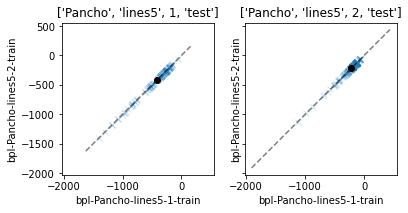

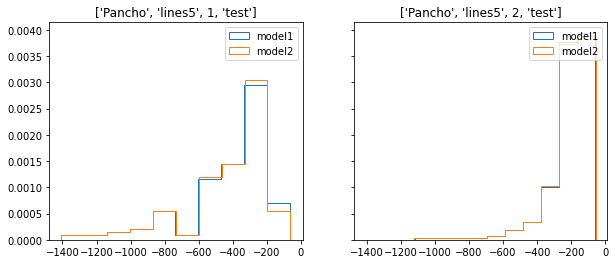

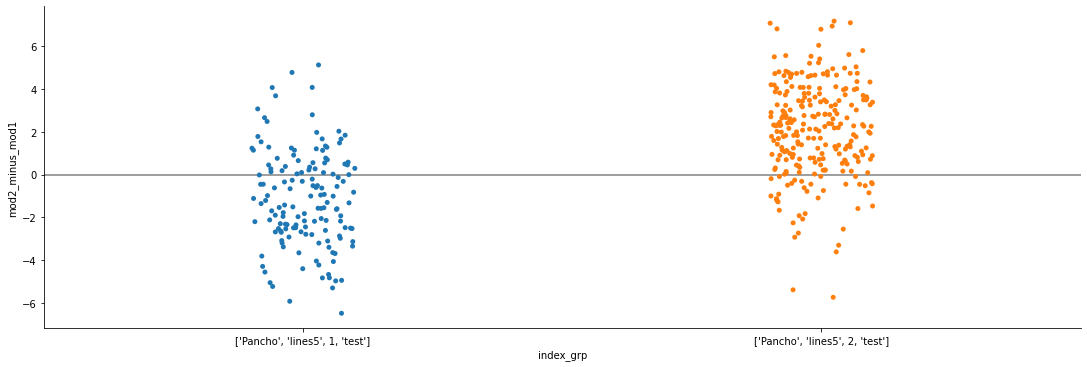

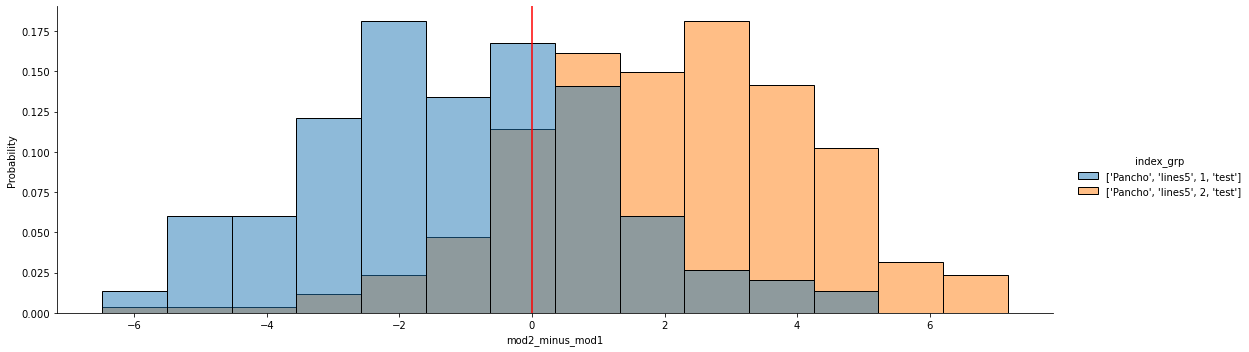

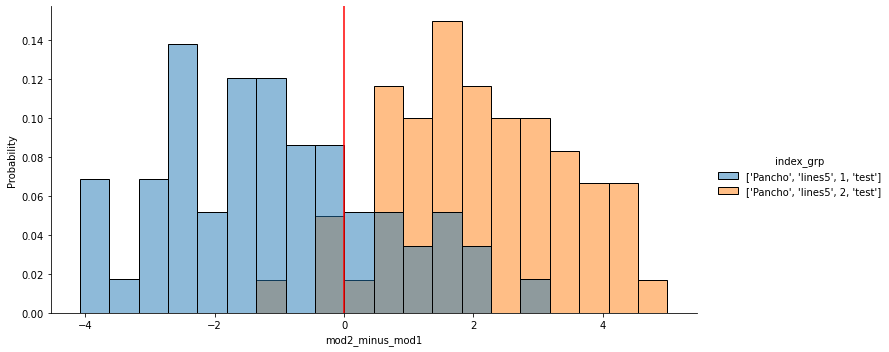

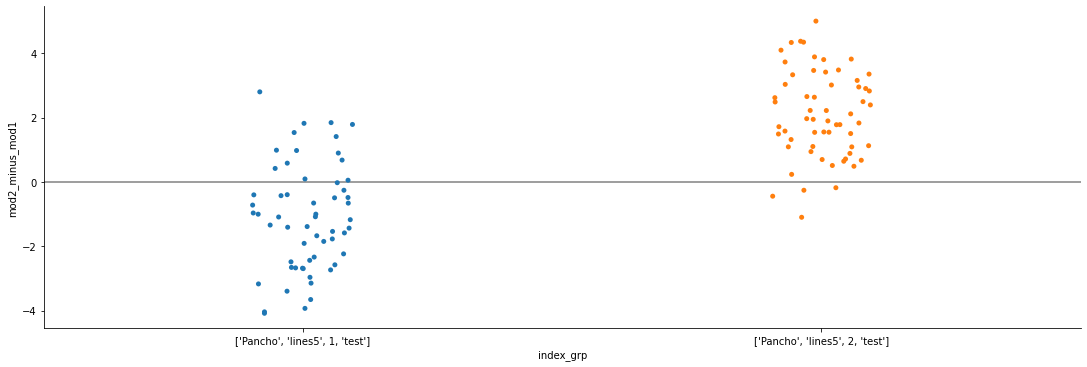

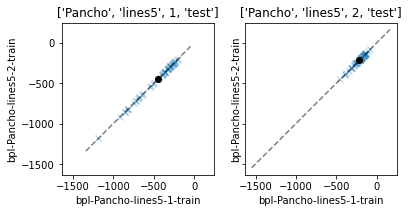

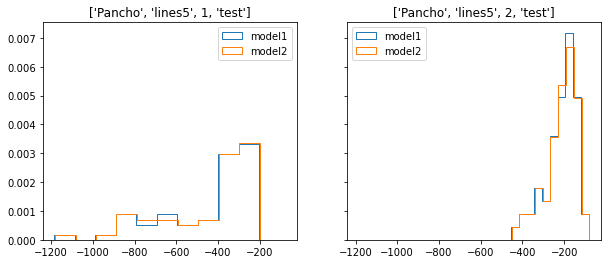

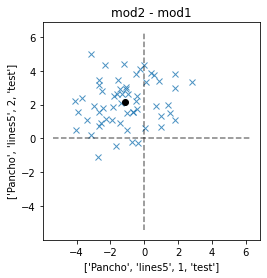

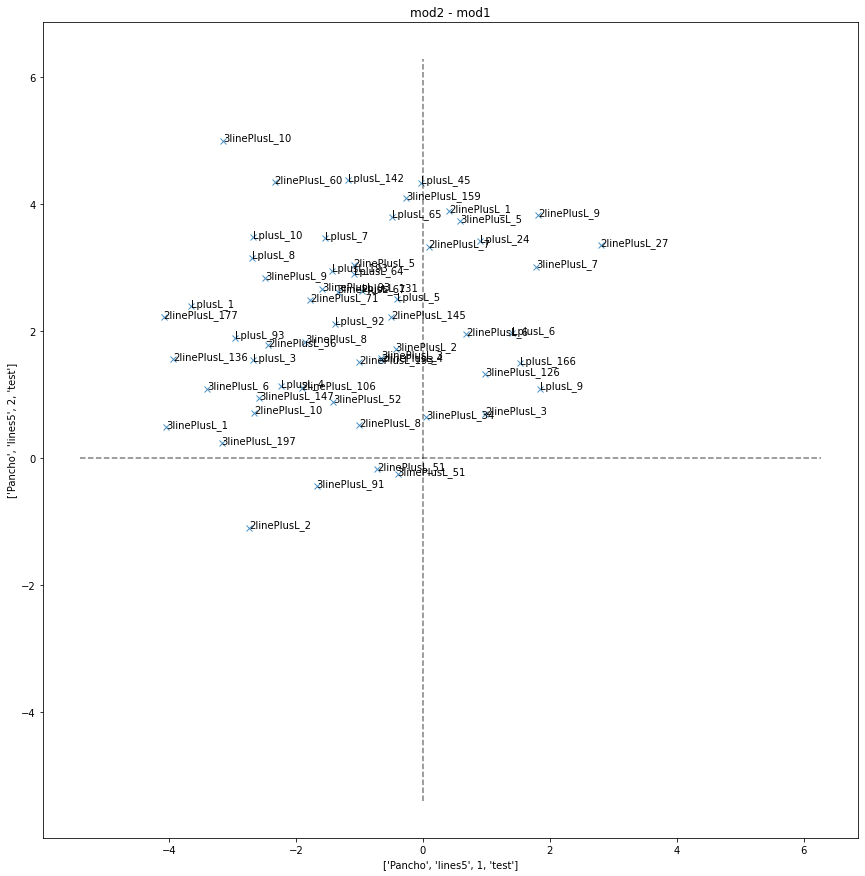

In [76]:
            from pythonlib.dataset.beh_model_comparison import plots_cross_prior_and_model
            monkey_prior_col_name = "index_grp"
            monkey_prior_list = ["['Pancho', 'lines5', 1, 'test']", "['Pancho', 'lines5', 2, 'test']"]
#             monkey_prior_list = list(DatThisTest[monkey_prior_col_name].unique())
            model_score_name_list = ["bpl-Pancho-lines5-1-train", "bpl-Pancho-lines5-2-train"]
            DatThisAggPaired = plots_cross_prior_and_model(DatThisTest, monkey_prior_col_name, monkey_prior_list, 
                                        model_score_name_list, return_DatThisAggPaired=True)

In [82]:
X = []
for model in model_score_name_list:
    for monkey in monkey_prior_list:
        X.append(np.mean(DatThisAggPaired[model][monkey]))
plt.figure()


[-447.71225, -217.78088, -448.82947, -215.6558]

In [ ]:
            # === plot all trials, top and bottom 20, ordered by model score diff

            # Top 20
            # _plotTrialsOrderedByModelScores(DatThis, order="fwd")
            fig = _plotTrialsOrderedByModelScores(DatThisTest, order="fwd")
            fig.savefig(f"{SDIR_PLOTS}/example_trials_scoresorted_testonly_mod1.pdf")

            # Bottom 20
            # _plotTrialsOrderedByModelScores(DatThis, order="rev")
            fig = _plotTrialsOrderedByModelScores(DatThisTest, order="rev")
            fig.savefig(f"{SDIR_PLOTS}/example_trials_scoresorted_testonly_mod2.pdf")

            import seaborn as sns
            # === PLOT OVERVIEW, ALL TASKS
            fig = sns.catplot(data=DatThisTest, x="index_grp", y="mod2_minus_mod1", aspect=3)
            plt.axhline(0, color="k", alpha=0.5)
            fig.savefig(f"{SDIR_PLOTS}/all_trials_test_catplot_summary_mod2minus1.pdf")
            # fig.savefig()

            # === PLOT OVERVIEW, ALL TASKS
            fig = sns.catplot(data=DatThis, x="index_grp", y="mod2_minus_mod1", aspect=3)
            plt.axhline(0, color="k", alpha=0.5)
            fig.savefig(f"{SDIR_PLOTS}/all_trials_traintest_catplot_summary_mod2minus1.pdf")
            # fig.savefig()


            # sns.displot(data=DatThis, hue="index_grp", x="mod2_minus_mod1", aspect=3, kind="hist")
            fig = sns.displot(data=DatThis, hue="index_grp", x="mod2_minus_mod1", aspect=3, kind="hist", 
                       stat="probability", common_norm=False)
            fig.savefig(f"{SDIR_PLOTS}/all_trials_traintest_summary_mod2minus1.pdf")


            fig = sns.displot(data=DatThisTest, hue="index_grp", x="mod2_minus_mod1", 
                        aspect=3, kind="hist", stat="probability", common_norm=False)

            fig.savefig(f"{SDIR_PLOTS}/all_trials_test_summary_mod2minus1.pdf")


            print("These are the 'alphabets' that exist during test")
            D.Dat[D.Dat["monkey_train_or_test"]=="test"]["task_stagecategory"].value_counts()


            ### ONE PLOT PER TASK
            # aggregate and average over all trials for agiven task

            # get list of tasks 
            from pythonlib.tools.pandastools import filterPandas, aggregGeneral
            DatThis = filterPandas(D.Dat, FiltTest)

            print("tasks that exist")
            print(DatThis["character"].value_counts())

            # aggregate over tasks
            tasklist = set(DatThis["character"])
            DatThisAgg = aggregGeneral(DatThis, group = ["character", column_dsets], values=["mod2_minus_mod1"])
            # seprate plots for each task category


            # from pythonlib.tools.snstools import relplotOverlaid
            # # relplotOverlaid(df=DatThisAgg, line_category="character", color="k", x=column_dsets, y="mod2_minus_mod1")
            # sns.relplot(data=DatThisAgg, hue="character", color="k", x=column_dsets, y="mod2_minus_mod1")

            fig = sns.displot(data=DatThisAgg, hue=column_dsets, x="mod2_minus_mod1", 
                        aspect=2, kind="hist", stat="probability", common_norm=False, bins=20,
                       element="bars", fill=True)
            plt.axvline(0, color="r")
            fig.savefig(f"{SDIR_PLOTS}/aggbytask_testG3_summary_mod2minus1.pdf")


            # === convert to paired.
            # def F(x):
            #     cols=["test", "test2"]
            #     return pd.Series([1, 2], index=cols)
            def F(x):
                cols=[str(column_levels[0]), str(column_levels[1])]
                def _getval(x, level):
                    val = x[x[column_dsets]==level]["mod2_minus_mod1"].values
                    if len(val)==0:
                        return np.nan
                    elif len(val)>1:
                        assert False
                    else:
                        return val[0]
                val1 = _getval(x, column_levels[0])
                val2 = _getval(x, column_levels[1])

                tmp = [val1, val2]
                tmp = pd.Series(tmp, index=cols)
                return tmp

            DatThisAggPaired = DatThisAgg.groupby(["character"]).apply(F).reset_index()

            ### OLD VERSION, USING PIVOT TABLE
            # DatThisAggPivot = pd.pivot_table(data=DatThisAgg, index="character", columns=["epoch"]).reset_index(drop=True)
            # x1 = DatThisAggPivot[("mod2_minus_mod1", 1)]
            # x2 = DatThisAggPivot[("mod2_minus_mod1", 2)]
            # plt.figure()
            # plt.hist(x1, histtype="step")
            # plt.hist(x2, histtype="step")

            # DatThisAggPivot.columns = ['_'.join([str(c) for c in col]).strip() for col in DatThisAggPivot.columns.values]


            # sns.scatterplot(data=DatThisAggPaired, x="epoch1", y="epoch2")

            from pythonlib.tools.plottools import plotScatter45
            cols = [str(column_levels[0]), str(column_levels[1])]
            col1 = cols[0]
            col2 = cols[1]

            x = DatThisAggPaired[col1]
            y = DatThisAggPaired[col2]
            tasknames = [v.split("-")[0] for v in DatThisAggPaired["character"].values]

            fig, ax = plt.subplots()
            plotScatter45(x, y, ax, dotted_lines="plus", means=True, labels = None)
            ax.set_xlabel(col1)
            ax.set_ylabel(col2)
            ax.set_title("mod2 - mod1")
            fig.savefig(f"{SDIR_PLOTS}/aggbytask_testG3_scatter_mod2minus1.pdf")


            fig, ax = plt.subplots(figsize=(15,15))
            plotScatter45(x, y, ax, dotted_lines="plus", means=False, labels = tasknames)
            ax.set_xlabel(col1)
            ax.set_ylabel(col2)
            ax.set_title("mod2 - mod1")
            fig.savefig(f"{SDIR_PLOTS}/aggbytask_testG3_scatter_mod2minus1_largetext.pdf")

            # plot all tasks


            def _plottask(taskthis, saveon=False):
                # Find inds in original dataframe
                df = D.Dat[D.Dat["character"]==taskthis]
                print("fouind this many for this task:")
                print(taskthis)
                print(len(df))

                column_vals = df[column_dsets].values
                mps = df["motor_program"].values
                scores = df["mod2_minus_mod1"].values
                idxs = list(df.index)

                fig = _plotTrialsOrderedByModelScores(df, titles=[f"ep {e}" for e in column_vals])
                if saveon:
                    fig.savefig(f"{SDIR_PLOTS}/indiv_task_testG3_{taskthis}.pdf")

                fig = D.plotSingleTrial(idxs[0], 
                                        things_to_plot = ["task"])
                if saveon:
                    fig.savefig(f"{SDIR_PLOTS}/indiv_task_testG3_{taskthis}_stim.pdf")


            # ITERATE OVER ALL TASKS

            for taskthis in set(DatThisAgg["character"]):
                _plottask(taskthis, saveon=True)


            # Closer all plots
            plt.close("all")

### RELOADING SINGLE BPL FITS AND MAKING PLOTS (PLOT PRIMITIVES)

In [ ]:
animallist = ["Pancho", "Red"]
# animallist = ["Red"]
expt="biasdir3"
# expt="lines5"
# modelverlist = [
#     "full", 'kappa', 'rel_type_mixture', 'prim_type_mixture', 'spatial_hist']
modelverlist = [
    "full", 'kappa', 'prim_type_mixture', 'spatial_hist']

animallist = ["Pancho", "Red"]
# animallist = ["Red"]
# expt="biasdir3"
expt="lines5"
# modelverlist = [
#     "full", 'kappa', 'rel_type_mixture', 'prim_type_mixture', 'spatial_hist']
modelverlist = [
    "full"]

DAT = []
for animal in animallist:
    for modelver in modelverlist:
        
        # Path, for loading.
        if isinstance(modelver, str):
            suffix = modelver
        elif isinstance(modelver, list):
            suffix = "_".join(modelver)
        pathlist = findPath("/data2/analyses/database/combined-bpl_refit/",
                 [[animal, expt, suffix]], "BPL", return_without_fname=True)

        # for each one, go and load 
        for path in pathlist:
            D = Dataset([path], reloading_saved_state=True)
            
            # Reload BPL
            path = D._reloading_saved_state_inputs[0]
            D.bpl_reload_saved_state(path)

            D, group, libraries_to_apply_inds, mod1, mod2, FiltTest, column_dsets, column_levels = params_by_expt(D, expt)
            

            
            #### PLOT - DISTRIBUTIONS OVER PRIMITIVES.
            SDIR_THIS = f"{path}/plots_primitives"
            import os
            os.makedirs(SDIR_THIS, exist_ok=True)

            from pythonlib.bpl.refitting import plotLibDists1D, plotLibDists2D
            from pybpl.model.model import CharacterModel as model
            from pythonlib.bpl.strokesToProgram import plotMP
            
            # General model - this should be fine, since the primitives shapes are not fit differently to each dataset.
            M = model(lib)


            #### PLOT SAMPLES FROM PRIOR
            # NOTE: problem, currnetly nsub is not 1, so can get many strokes, even if k is low.
            # Not a problem fro scoring, but is for sampling.
            if False:
                def _plotSamplesPrior(lib):

                    img_list = []
                    ctype_list = []
                    for i in range(10):
                        try:
                            ctype = M.sample_type()
                            ctoken = M.sample_token(ctype)
                            img = M.sample_image(ctoken)
                            img_list.append(img)
                            ctype_list.append(ctype)
                        except:
                            pass


                    nrow = 2
                    ncol = 5
                    fig, axes = plt.subplots(nrow, ncol, figsize=(ncol*2, nrow*2))
                    for img, ctype, ax in zip(img_list, ctype_list, axes.flatten()):
                    #     ax.imshow(img)
                        plotMP(ctype, ax=ax)

                for idx in range(4):
                    lib = D.BPL["refits"][0]["libraries"][idx]["lib"]
                    print(D.BPL["refits"][0]["libraries"][idx]["index_grp"])
                    _plotSamplesPrior(lib)

            def _plot_primitive(idx, ax=None):
                ids=torch.tensor([idx])
                shapes = M.type_dist.pdist.sample_shapes_type(ids)
                invscales = M.type_dist.pdist.sample_invscales_type(ids)
                
                XYLIM = 65
                
                # Version 1, go straight to motor.
                if False:
                    from pybpl.objects.part import vanilla_to_motor
                    motor, motor_spline = vanilla_to_motor(shapes, invscales, torch.tensor([0,0]))
                    motor = motor.numpy().squeeze()
                    motor_spline = motor_spline.numpy().squeeze()

                    fig, ax = plt.subplots()
                    from pythonlib.drawmodel.strokePlots import plotDatStrokes

                    plotDatStrokes([motor], ax)
                    ax.set_xlim([-XYLIM, XYLIM])
                    ax.set_ylim([-XYLIM, XYLIM])



                # Version 2, use model methods
                from pybpl.objects.part import StrokeType

                ptype = StrokeType(ids, ids, shapes, invscales)
                ptoken = M.token_dist.pdist.sample_part_token(ptype)
                setattr(ptoken, "position", torch.tensor([0,0]))

                motor = ptoken.motor.numpy().squeeze()
                # motor_spline = motor_spline.numpy().squeeze()

                if ax is None:
                    fig, ax = plt.subplots()
                from pythonlib.drawmodel.strokePlots import plotDatStrokes

                plotDatStrokes([motor], ax)
                ax.set_xlim([-XYLIM, XYLIM])
                ax.set_ylim([-XYLIM, XYLIM])    

            def _plot_topN_by_probs(probs, N=40):
                """ plot top higherst prob, in decresaing order
                probs must give assignment of prob to each index (in same order).
                """

                # plot top N primitives
                inds = np.argsort(probs)[::-1]
                probsthis = [probs[i] for i in inds]

                ncols = 10
                nrows = int(np.ceil(N/ncols))

                indsthis = inds[:N]
                probsthisthis = probsthis[:N]

                fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2))
                for i, ax, p in zip(indsthis, axes.flatten(), probsthisthis):
                    _plot_primitive(i, ax)
                    ax.set_title(f"{int(i)}|{p:.3f}")

                return fig

            # == primitives that are most common for each library
            for idx in range(4):
                lib = D.BPL["refits"][0]["libraries"][idx]["lib"]
                name = D.BPL["refits"][0]["libraries"][idx]["index_grp"]

                probs = torch.exp(lib.logStart).numpy()
                fig = _plot_topN_by_probs(probs)

                fname = "_".join([str(x) for x in name])
                sdirthis = f"{SDIR_THIS}/topN_single_libs"
                os.makedirs(sdirthis, exist_ok=True)
                fig.savefig(f"{sdirthis}/{fname}.pdf")



            # == primitives that are most different across 2 libraries
            indslists = [
                [1, 3],
                [3, 1],
                [0, 2],
                [2, 0]
            ]

            for [idx1, idx2] in indslists:

                lib1 = D.BPL["refits"][0]["libraries"][idx1]["lib"]
                name1 = D.BPL["refits"][0]["libraries"][idx1]["index_grp"]

                lib2 = D.BPL["refits"][0]["libraries"][idx2]["lib"]
                name2 = D.BPL["refits"][0]["libraries"][idx2]["index_grp"]
                print(name2, "minus", name1)

                # log_prob_diffs = torch.exp(lib2.logStart) - torch.exp(lib1.logStart)
                prob_diffs = torch.exp(lib2.logStart) - torch.exp(lib1.logStart)
                probs = prob_diffs.numpy()

                fig = _plot_topN_by_probs(probs)

                fname = "_".join([str(x) for x in name2]) + "-MIN-" + "_".join([str(x) for x in name1])

                sdirthis = f"{SDIR_THIS}/topN_compare_libs"
                os.makedirs(sdirthis, exist_ok=True)
                fig.savefig(f"{sdirthis}/{fname}.pdf")



## RELOADING MULITPLE PREVIUSLY SAVED MODEL FITS AND SCORES (ABOVE) AND DOING PLOTS ACROSS DIFFERENT MODEL FITS


In [ ]:

animallist = ["Pancho", "Red"]
# animallist = ["Red"]
# expt="biasdir3"
expt="lines5"
# modelverlist = [
#     "full", 'kappa', 'rel_type_mixture', 'prim_type_mixture', 'spatial_hist']
modelverlist = [
    "full", 'kappa', 'prim_type_mixture', 'spatial_hist']

# def _get_mod1_mod2(animal):
#     mod1 = (animal, expt, 1, 'train')
#     mod2 = (animal, expt, 2, 'train')
#     return mod1, mod2


from pythonlib.tools.expttools import makeTimeStamp
ts = makeTimeStamp()
dirname = f"{'_'.join(animallist)}-{expt}-{ts}"
SDIR_THIS = f"{SDIR_MAIN}/combined_plots/{dirname}"
import os
os.makedirs(SDIR_THIS, exist_ok=True)

print("Saving at:")
print(SDIR_THIS)

def _plotall(DatThisAggPairedAll, DatThisAggAll):
    import seaborn as sns
    from pythonlib.tools.snstools import rotateLabel
    fig = sns.catplot(data=DatThisAggPairedAll, x="modelver", row="animal", y="score", color="k")
    rotateLabel(fig)
    plt.axhline(0, color="k", alpha=0.5)
    fig.savefig(f"{SDIR_THIS}/allmodels_alignmentscore_eachtask_1.pdf")
    
    fig = sns.catplot(data=DatThisAggPairedAll, x="modelver", row="animal", y="score", kind="boxen")
    rotateLabel(fig)
    plt.axhline(0, color="k", alpha=0.5)
    fig.savefig(f"{SDIR_THIS}/allmodels_alignmentscore_eachtask_2.pdf")
    
    fig = sns.catplot(data=DatThisAggPairedAll, x="modelver", hue="animal", y="score", kind="point", ci=68)
    rotateLabel(fig)
    plt.axhline(0, color="k", alpha=0.5)
    fig.savefig(f"{SDIR_THIS}/allmodels_alignmentscore_eachtask_3.pdf")
    
    fig = sns.catplot(data=DatThisAggPairedAll, x="modelver", row="animal", y="score", alpha=0.5, color="k")
    fig.map(sns.pointplot, data=DatThisAggPairedAll, x="modelver", y="score", color="k", ci=68)
    plt.axhline(0, color="k", alpha=0.5)    
    rotateLabel(fig)
    plt.axhline(0, color="k", alpha=0.5)
    fig.savefig(f"{SDIR_THIS}/allmodels_alignmentscore_eachtask_4.pdf")
    
    fig = sns.displot(data=DatThisAggAll, col="animal", row="modelver", hue="epoch", x="mod2_minus_mod1", 
            aspect = 2.5, height=5, kind="hist", 
                       stat="probability", common_norm=False)
    fig.savefig(f"{SDIR_THIS}/allmodels_hists_eachtask_1.pdf")


# _plotall(DatThisAggPairedAll)


DAT = []
for animal in animallist:
    for modelver in modelverlist:
        
        # Path, for loading.
        if isinstance(modelver, str):
            suffix = modelver
        elif isinstance(modelver, list):
            suffix = "_".join(modelver)
        pathlist = findPath("/data2/analyses/database/combined-bpl_refit/",
                 [[animal, expt, suffix]], "BPL", return_without_fname=True)

        # for each one, go and load 
        for path in pathlist:
            D = Dataset([path], reloading_saved_state=True)
            
            # Reload BPL
            path = D._reloading_saved_state_inputs[0]
            D.bpl_reload_saved_state(path)

            D, group, libraries_to_apply_inds, mod1, mod2, FiltTest, column_dsets, column_levels = params_by_expt(D, expt)
            
            # ====
#             mod1, mod2 = _get_mod1_mod2(animal)
#             D.Dat["mod2_minus_mod1"] = list(D.Dat[D.bpl_index_to_col_name(mod2)] - D.Dat[D.bpl_index_to_col_name(mod1)])
            D.Dat["mod2_minus_mod1"] = list(D.Dat[D.bpl_index_to_col_name(mod2)] - D.Dat[D.bpl_index_to_col_name(mod1)])

            # === get aggregated summary dataframe.

            # get list of tasks 
            from pythonlib.tools.pandastools import filterPandas
#             F = {"monkey_train_or_test":["test"],
#             #      "character":[],
#                  "taskgroup":["G3"]}
            DatThis = filterPandas(D.Dat, FiltTest)

            print("tasks that exist")
            print(DatThis["character"].value_counts())

            # aggregate over tasks
            tasklist = set(DatThis["character"])
            from pythonlib.tools.pandastools import aggregGeneral
            DatThisAgg = aggregGeneral(DatThis, group = ["character", column_dsets], values=["mod2_minus_mod1"])
            # seprate plots for each task category

            # def F(x):
            #     cols=["test", "test2"]
            #     return pd.Series([1, 2], index=cols)
            def F(x):
                cols=[str(column_levels[0]), str(column_levels[1])]
                def _getval(x, level):
                    val = x[x[column_dsets]==level]["mod2_minus_mod1"].values
                    if len(val)==0:
                        return np.nan
                    elif len(val)>1:
                        assert False
                    else:
                        return val[0]
                val1 = _getval(x, column_levels[0])
                val2 = _getval(x, column_levels[1])

                tmp = [val1, val2]
                tmp = pd.Series(tmp, index=cols)
                return tmp

            DatThisAggPaired = DatThisAgg.groupby(["character"]).apply(F).reset_index()

            print(DatThisAgg[:5])
            print(DatThisAggPaired[:5])

            # === SAVE FOR COMPARISON
            DAT.append({
                "animal":animal,
                "modelver":modelver,
                "suffix":suffix,
                "path":path,
                "DatThisAggPaired":DatThisAggPaired,
                "DatThisAgg":DatThisAgg})

# get summary, which is mean of mod2-mod1 (but flipped if considering epoch1)
def F(x):
    if np.isnan(x[column_levels[0]]) | np.isnan(x[column_levels[1]]):
        return np.nan
    return (x[column_levels[1]] - x[column_levels[0]])/2
#     assert False
from pythonlib.tools.pandastools import applyFunctionToAllRows

# DatThisAggPaired = applyFunctionToAllRows(DatThisAggPaired, F, "score")

for D in DAT:
    D["DatThisAggPaired"] = applyFunctionToAllRows(D["DatThisAggPaired"], F, "score")

### PLOT SUMMARY ACROSS ALL EXPTS

# For each dataset, 
# Flatten DAT

DatThisAggPairedAll = []
for D in DAT:
    dfthis = D["DatThisAggPaired"]
    dfthis["animal"] = D["animal"]
    dfthis["modelver"] = D["modelver"]

    DatThisAggPairedAll.append(dfthis)
    
DatThisAggAll = []
for D in DAT:
    dfthis = D["DatThisAgg"]
    dfthis["animal"] = D["animal"]
    dfthis["modelver"] = D["modelver"]

    DatThisAggAll.append(dfthis)

DatThisAggPairedAll = pd.concat(DatThisAggPairedAll).reset_index(drop=True)
DatThisAggAll = pd.concat(DatThisAggAll).reset_index(drop=True)


# == plot
_plotall(DatThisAggPairedAll, DatThisAggAll)


### OLDER SCRATCH (during vevelopmeing of main)

In [ ]:
from pythonlib.bpl.strokesToProgram import lib

plt.figure()
plt.imshow(lib.pmat_nsub.numpy())

plt.figure()
plt.plot(lib.logStart, "-ok")

lib.pT.

In [ ]:
# PICK OUT EXAMPLES BY EYE TO PLOT ALL TRIALS
if False:
    taskname_part = "3linePlusL_10"
    taskname_part = "LplusL_10"
    taskname_part = "LplusL_1"
    taskname_part = "3linePlusL_126"

    # find the original full name
    taskthis = [t for t in tasklist if taskname_part+"-" in t]
    assert len(taskthis)==1
    taskthis = taskthis[0]




In [ ]:
# # ==== CONDITION ON ONE DATASET, GET SCORE USING DIFFERENT LIBRARIES
# # # === For each trial index, get its difference from a fixed one
# from pythonlib.tools.snstools import rotateLabel
# import seaborn as sns

# def crossscore_condOnDat(dat_index_list):
#     for dat_index in dat_index_list:
#         print("-- DOING DAT:")
#         print(dat_index)
#         ScoresLibsDats = []
#         nthis = 0
#         for g1 in D.Dat.groupby(gb):
#             print(f"-- {nthis} -- lib: {g1[0]}")
#             nthis += 1

#             lib_index = g1[0]
#             scores = scoreLibDat(libraries_list, lib_index, dat_index)

#             # expand scores
#             for j, s in enumerate(scores):
#                 ScoresLibsDats.append(
#                     {"lib_index":lib_index,
#                      "dat_index":dat_index,
#                      "score":s.numpy(),
#                      "trial_index_inorder":j
#                     })


#         ScoresLibsDats = pd.DataFrame(ScoresLibsDats)
#         ScoresLibsDats[:5]

#         def F(x):
#         #     print(x)
#         #     print(x - x.values[0])
#         #     sdafds
#         #     return x
#             return x - x.values[0]


#         # === For each trial index, get its difference from a fixed one
#         ScoresLibsDats = pd.DataFrame(ScoresLibsDats)
#         ScoresLibsDats["score_norm"] = ScoresLibsDats.groupby(["trial_index_inorder"])["score"].transform(F)

#         ax = sns.catplot(data = ScoresLibsDats, x="lib_index", y="score_norm", kind="point", aspect=3)
#         rotateLabel(ax)
#         ax.fig.suptitle(dat_index)


In [ ]:
# === FIND TASK THAT IS MOST DIFFERENTLY SCORED ACROSS MODELS
ScoresLibsDats

In [ ]:
# === 

In [ ]:
# ScoresLibsDats = pd.DataFrame(ScoresLibsDats)

# for g in ScoresLibsDats.groupby(["trial_index_inorder"]):
#     ind = g[1]["lib_index"]==dat_index
#     assert sum(ind)==1, "only one should be the one to align to"
#     s_base = g[1][ind]
#     print(s_base["score"])
#     assert False

In [ ]:
s1 = scoreLibDat(libraries_list, ('Red', 'arc2', 1, 'train'), ('Red', 'arc2', 1, 'test'))
s2 = scoreLibDat(libraries_list, ('Red', 'arc2', 1, 'test'), ('Red', 'arc2', 1, 'test'))



In [ ]:
_plot_compare_scores(s1, s2)

In [ ]:
# === compare library distributions


In [ ]:
#     def score_type(self, ctype):
#         """
#         Compute the log-probability of a concept type under the prior
#         $P(type) = P(k)*\prod_{i=1}^k [P(S_i)P(R_i|S_{0:i-1})]$

#         Parameters
#         ----------
#         ctype : ConceptType
#             concept type to score

#         Returns
#         -------
#         ll : tensor
#             scalar; log-probability of the concept type
#         """
#         assert isinstance(ctype, ConceptType)
#         # score the number of parts
#         ll = 0.
#         ll = ll + self.score_k(ctype.k)
#         # step through and score each part
#         for i in range(ctype.k):
#             ll = ll + self.pdist.score_part_type(ctype.k, ctype.part_types[i])
#             ll = ll + self.rdist.score_relation_type(
#                 ctype.part_types[:i], ctype.relation_types[i]
#             )

#         return ll


## OLD THINGS (for refitting and analysing)

In [ ]:
# === get score for a given library and dataset

def subsetDataset(dat_index):
    """
    - e..g, dat_index = ('Pancho', 'arc2', 1, 'test')
    RETURNS:
    - df, subset of D.Dat
    """
    i1 = D.Dat[gb[0]]==dat_index[0]
    i2 = D.Dat[gb[1]]==dat_index[1]
    i3 = D.Dat[gb[2]]==dat_index[2]
    i4 = D.Dat[gb[3]]==dat_index[3]
    df = D.Dat[i1 & i2 & i3 & i4]
    return df

    
def scoreLibDat(libraries_list, lib_index, dat_index, scores_to_use = ["type"]):
    """
    
    """
    assert isinstance(lib_index, tuple)
    assert isinstance(dat_index, tuple)
    
    # get library
    Lthis = [L for L in libraries_list if L["index_grp"]==lib_index]
    if len(Lthis)==0:
        print(lib_index)
        assert False, "did not find for this lib_index"
    if len(Lthis)>1:
        assert False
    Lthis = Lthis[0]
    libthis = Lthis["lib"]
            
    # get datsaet
    df = subsetDataset(dat_index)
#     i1 = D.Dat[gb[0]]==dat_index[0]
#     i2 = D.Dat[gb[1]]==dat_index[1]
#     i3 = D.Dat[gb[2]]==dat_index[2]
#     i4 = D.Dat[gb[3]]==dat_index[3]
#     df = D.Dat[i1 & i2 & i3 & i4]
    MPlist_this = list(df["motor_program"].values)
    
    # do score
    scores = torch.tensor(scoreMPs(MPlist_this, lib=libthis, scores_to_use=scores_to_use))
    
    return scores
    


## [OLD, THIS CAN TAKE FOREVER!!] get cross of all libraries and datasets
## This can take forever!!


In [ ]:
# [OLD, THIS CAN TAKE FOREVER!!] get cross of all libraries and datasets
# This can take forever!!
MAXGRP = 20
ScoresLibsDats = []

# first check how many groups there are
ngroups = 0
for g in D.Dat.groupby(gb):
    ngroups += 1
if ngroups>MAXGRP:
    print(ngroups)
    assert False, "too many groups (cross product)"


group_indexes = []
nthis = 0
for g1 in D.Dat.groupby(gb):
    for g2 in D.Dat.groupby(gb):
        print(f"-- {nthis} -- lib, dat: {g1[0]} ,{g2[0]}")
        nthis += 1
        
        lib_index = g1[0]
        dat_index = g2[0]
        scores = scoreLibDat(libraries_list, lib_index, dat_index)
        
        ScoresLibsDats.append(
            {"lib_index":lib_index,
             "dat_index":dat_index,
             "scores":scores})
        
    

# === flatten, one score per row
ScoresLibsDatsFlat = []
for S in ScoresLibsDats:
    lib_index = S["lib_index"]
    dat_index = S["dat_index"]
    scores = S["scores"]
    for s in scores:
        ScoresLibsDatsFlat.append(
            {"lib_index":lib_index,
             "dat_index":dat_index,
             "s":s.numpy()})


ScoresLibsDatsFlat = pd.DataFrame(ScoresLibsDatsFlat)        
ScoresLibsDatsFlat["s"] = np.stack(ScoresLibsDatsFlat["s"].values)

In [ ]:
from pythonlib.tools.snstools import rotateLabel
import seaborn as sns

ax = sns.catplot(data=ScoresLibsDatsFlat, x="lib_index", y="s", row = "dat_index", kind="point")
rotateLabel(ax)


### CONDITION ON ONE DATASET, GET SCORE USING DIFFERENT LIBRARIES


In [ ]:
# ==== CONDITION ON ONE DATASET, GET SCORE USING DIFFERENT LIBRARIES
# # === For each trial index, get its difference from a fixed one
from pythonlib.tools.snstools import rotateLabel
import seaborn as sns

def crossscore_condOnDat(dat_index_list):
    for dat_index in dat_index_list:
        print("-- DOING DAT:")
        print(dat_index)
        ScoresLibsDats = []
        nthis = 0
        for g1 in D.Dat.groupby(gb):
            print(f"-- {nthis} -- lib: {g1[0]}")
            nthis += 1

            lib_index = g1[0]
            scores = scoreLibDat(libraries_list, lib_index, dat_index)

            # expand scores
            for j, s in enumerate(scores):
                ScoresLibsDats.append(
                    {"lib_index":lib_index,
                     "dat_index":dat_index,
                     "score":s.numpy(),
                     "trial_index_inorder":j
                    })


        ScoresLibsDats = pd.DataFrame(ScoresLibsDats)
        ScoresLibsDats[:5]

        def F(x):
        #     print(x)
        #     print(x - x.values[0])
        #     sdafds
        #     return x
            return x - x.values[0]


        # === For each trial index, get its difference from a fixed one
        ScoresLibsDats = pd.DataFrame(ScoresLibsDats)
        ScoresLibsDats["score_norm"] = ScoresLibsDats.groupby(["trial_index_inorder"])["score"].transform(F)

        ax = sns.catplot(data = ScoresLibsDats, x="lib_index", y="score_norm", kind="point", aspect=3)
        rotateLabel(ax)
        ax.fig.suptitle(dat_index)


In [ ]:
dat_index_list = [
    (animal, 'lines5',1, 'test'),
    (animal, 'lines5',2, 'test'),
]

crossscore_condOnDat(dat_index_list)

In [ ]:
[X["index_grp"] for X in D.BPL["refits"][0]["libraries"]]

In [ ]:
D.BPL["refits"][0].keys()